# Статистика по индексу MIX(индекс мосбиржи) на основе дней в неделе.

Статистика по направлениям свечей в зависимости от дня недели.  
Проверка гипотезы на торговлю в определенные дни недели.

### Об используемых в исследовании данных  
В настоящем исследовании используются дневные котировки на фьючерс индекса Московской биржи, скаченные с сервера МБ через ISS API, с 2015 года.  
Цена открытия каждого бара соответствует времени начала вечерней дополнительной торговой сесии предыдущего торгового дня (19:05).  
В базе данных котировки храняться на разные контракты, переход на новый котракт происходить по истечении предыдущего. Т.к. новый контракт по отношению к истекающему обычно находится положении контанго, переход с контракта на контракт сопровождается гэпом. В исследовании применяется расчет только тела свечи, поэтому гэпы не влияют на статистический результат. Междневные гэпы (не межконтрактрые) минимальны в силу того что между закрытием одной свечи и открытием другой проходит всего 15 минут (с 18:50 до 19:05). Информацию по гэпам стоит иметь ввиду при реальной торговле.



## Статистическое исследование.

Подключение гугл диска

In [102]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Подключение к БД.

In [103]:
import pandas as pd
import numpy as np
import sqlite3
import datetime

In [104]:
connection = sqlite3.connect(r'/content/drive/MyDrive/data_quote_db/MIX_futures_day.db', check_same_thread=True)  # Создание соединения с БД

Загрузка данных в таблицу pandas.

In [105]:
with connection:
  df = pd.read_sql('SELECT * FROM Day', connection)  # Загрузка данных из БД

print(df.to_string(max_rows=6, max_cols=25))  # Проверка того, что загрузилось

       TRADEDATE      SECID      OPEN       LOW      HIGH     CLOSE  VOLUME  OPENPOSITION SHORTNAME    LSTTRADE
0     2015-01-05  MXH5_2015  142000.0  138525.0  145950.0  145150.0    2587         12938  MIX-3.15  2015-03-16
1     2015-01-06  MXH5_2015  144750.0  144350.0  149900.0  149900.0    2953         12760  MIX-3.15  2015-03-16
2     2015-01-08  MXH5_2015  149500.0  148200.0  158200.0  156025.0    5567         15098  MIX-3.15  2015-03-16
...          ...        ...       ...       ...       ...       ...     ...           ...       ...         ...
2265  2024-01-18       MXH4  326775.0  326025.0  327675.0  326050.0   13969         90338  MIX-3.24  2024-03-21
2266  2024-01-19       MXH4  326650.0  323400.0  327150.0  325175.0   20906         91028  MIX-3.24  2024-03-21
2267  2024-01-22       MXH4  325150.0  323925.0  326300.0  325825.0   16332         90764  MIX-3.24  2024-03-21


Подготовка DF

In [106]:
df = df.drop(['SECID', 'OPENPOSITION', 'SHORTNAME', 'LSTTRADE'], axis=1)
df['TRADEDATE'] = pd.to_datetime(df['TRADEDATE'])  # Смена типа
df = df.dropna().reset_index(drop=True)  # Удаление NaN

Создание и заполнение колонки с торговым днем недели (Work_day).  
0 - Понедельник  
1 - Вторник  
и т.д.

In [107]:
df['Work_day'] = df['TRADEDATE'].dt.weekday

df[['Work_day']] = df[['Work_day']].astype(int)
df = df.sort_values(by='TRADEDATE', ascending=True)  # Сортировка по возрастанию
print(df.to_string(max_rows=6, max_cols=25))  # Проверка

      TRADEDATE      OPEN       LOW      HIGH     CLOSE  VOLUME  Work_day
0    2015-01-05  142000.0  138525.0  145950.0  145150.0    2587         0
1    2015-01-06  144750.0  144350.0  149900.0  149900.0    2953         1
2    2015-01-08  149500.0  148200.0  158200.0  156025.0    5567         3
...         ...       ...       ...       ...       ...     ...       ...
2265 2024-01-18  326775.0  326025.0  327675.0  326050.0   13969         3
2266 2024-01-19  326650.0  323400.0  327150.0  325175.0   20906         4
2267 2024-01-22  325150.0  323925.0  326300.0  325825.0   16332         0


Добавление колонок: направления бара и размера тела свечи.  
Если бар понижающийся то размер тела бара отрицательный.

In [108]:
df['Up'] = df.apply(lambda x: 1 if (x['OPEN'] < x['CLOSE']) else np.nan, axis=1)
df['Down'] = df.apply(lambda x: 1 if (x['OPEN'] >= x['CLOSE']) else np.nan, axis=1)
df['Body'] = df.apply(lambda x: -x['OPEN'] + x['CLOSE'], axis=1)
print(df.to_string(max_rows=6, max_cols=25))  # Проверка

      TRADEDATE      OPEN       LOW      HIGH     CLOSE  VOLUME  Work_day   Up  Down    Body
0    2015-01-05  142000.0  138525.0  145950.0  145150.0    2587         0  1.0   NaN  3150.0
1    2015-01-06  144750.0  144350.0  149900.0  149900.0    2953         1  1.0   NaN  5150.0
2    2015-01-08  149500.0  148200.0  158200.0  156025.0    5567         3  1.0   NaN  6525.0
...         ...       ...       ...       ...       ...     ...       ...  ...   ...     ...
2265 2024-01-18  326775.0  326025.0  327675.0  326050.0   13969         3  NaN   1.0  -725.0
2266 2024-01-19  326650.0  323400.0  327150.0  325175.0   20906         4  NaN   1.0 -1475.0
2267 2024-01-22  325150.0  323925.0  326300.0  325825.0   16332         0  1.0   NaN   675.0


Агрегация данных.

In [109]:
agg_func_count = {'Up': ['count'],
                  'Down': ['count'],
                  'Body': ['sum']}
df_count = df.groupby(['Work_day']).agg(agg_func_count)  # статистика по Up / Down
df_count.columns = ['_'.join(col).rstrip('_') for col in df_count.columns.values]  # Объединение названий колонок
df_count

,Up_count,Down_count,Body_sum
Work_day,,,
0,252,187,57500.0
1,240,213,172750.0
2,244,212,84150.0
3,221,238,-151300.0
4,220,236,-75525.0
5,4,1,1875.0


Добавление колоки разницы между Up и Down (Up-Down) по количеству.

In [110]:
df_count['Up-Down'] = df_count.apply(lambda x: x['Up_count'] - x['Down_count'], axis=1)
df_count[['Up-Down']] = df_count[['Up-Down']].astype(int)
df_count

,Up_count,Down_count,Body_sum,Up-Down
Work_day,,,,
0,252,187,57500.0,65
1,240,213,172750.0,27
2,244,212,84150.0,32
3,221,238,-151300.0,-17
4,220,236,-75525.0,-16
5,4,1,1875.0,3


По результатам статистики видно, что покупки по понедельникам, вторникам и средам дают положительный результат в симуляционной оценке торговли по телу свечи.

## Проверка гипотезы торговли по дням недели.  
Из статистики видно, что покупки в понедельник, вторник и среду дают прибыль. А в четверг и пятницу прибыль дают продажи.  
Для наглядности построим графики кривых доходности по дням и по совокупностям дней, чтобы видуально оценить результат.

## Графики результатов при покупках и продажах по дням недели.

Строим графики результатов при покупках в понедельник, вторник, среду и при продажах в четверг, пятницу.

Построение графика результата при покупке по понедельникам.  


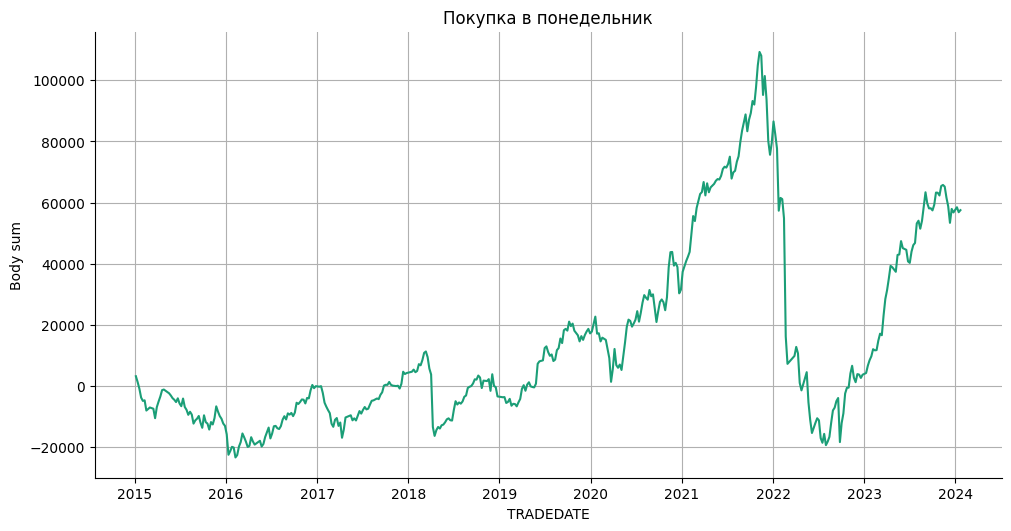

In [111]:
df_monday = df.copy(deep=True)  # Создание копии
df_monday = df_monday.loc[df_monday['Work_day'] == 0]  # Выборка по понедельникам
df_monday["Body_cum"] = df_monday["Body"].cumsum()
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['TRADEDATE']
  ys = series['Body_cum']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_monday.sort_values('TRADEDATE', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('TRADEDATE')
plt.title('Покупка в понедельник')
plt.grid()
_ = plt.ylabel('Body sum')

Очень большая просадка на СВО.

---

Построение графика результата при покупке по вторникам.  

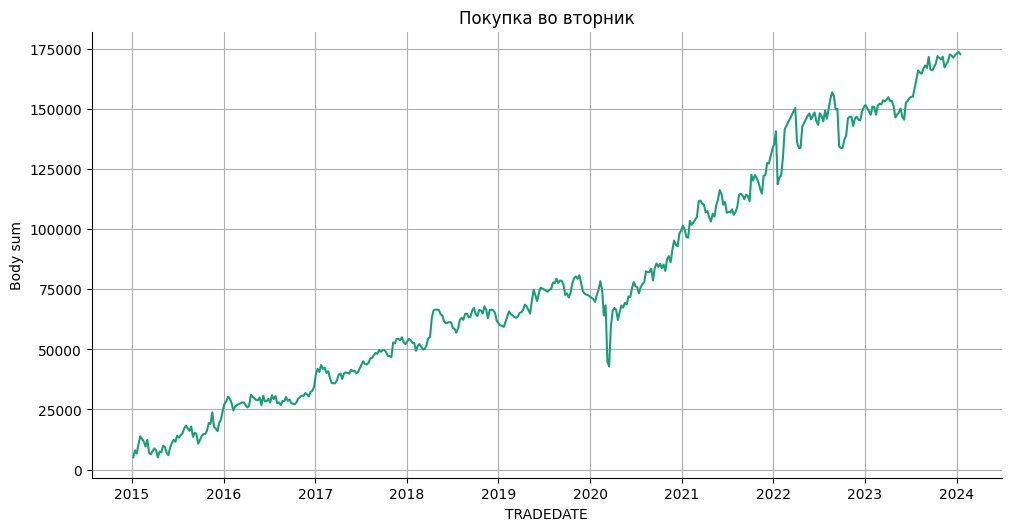

In [112]:
df_tuesday = df.copy(deep=True)  # Создание копии
df_tuesday = df_tuesday.loc[df_tuesday['Work_day'] == 1]  # Выборка по вторникам
df_tuesday["Body_cum"] = df_tuesday["Body"].cumsum()
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['TRADEDATE']
  ys = series['Body_cum']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_tuesday.sort_values('TRADEDATE', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('TRADEDATE')
plt.title('Покупка во вторник')
plt.grid()
_ = plt.ylabel('Body sum')

Заметная просадка на КОВИД.

---

Построение графика результата при покупке по средам.

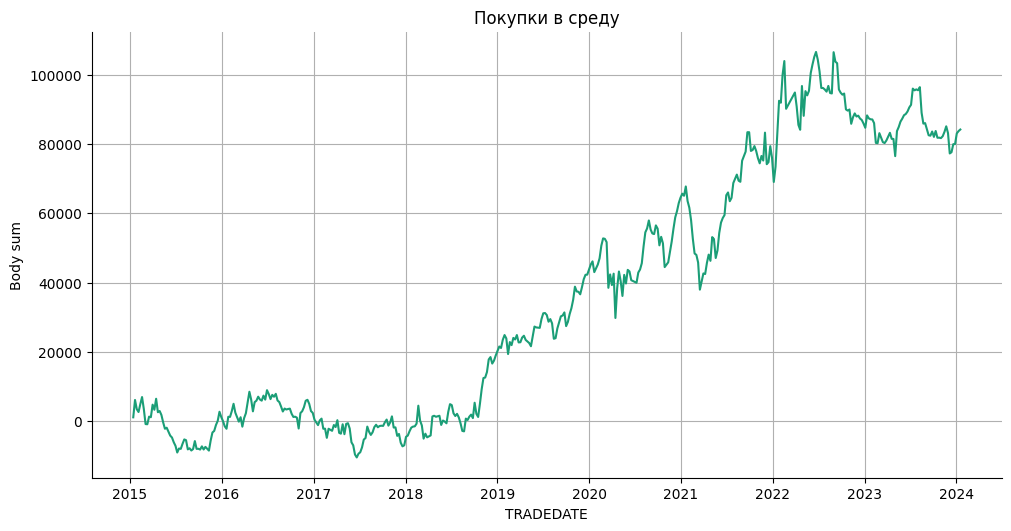

In [113]:
df_wednesday = df.copy(deep=True)  # Создание копии
df_wednesday = df_wednesday.loc[df_wednesday['Work_day'] == 2]  # Выборка по средам
df_wednesday["Body_cum"] = df_wednesday["Body"].cumsum()
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['TRADEDATE']
  ys = series['Body_cum']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_wednesday.sort_values('TRADEDATE', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('TRADEDATE')
plt.title('Покупки в среду')
plt.grid()
_ = plt.ylabel('Body sum')

Не однозначный результат, есть продолжительные периоды без роста.

---

Построение графика результата при покупке по четвергам.

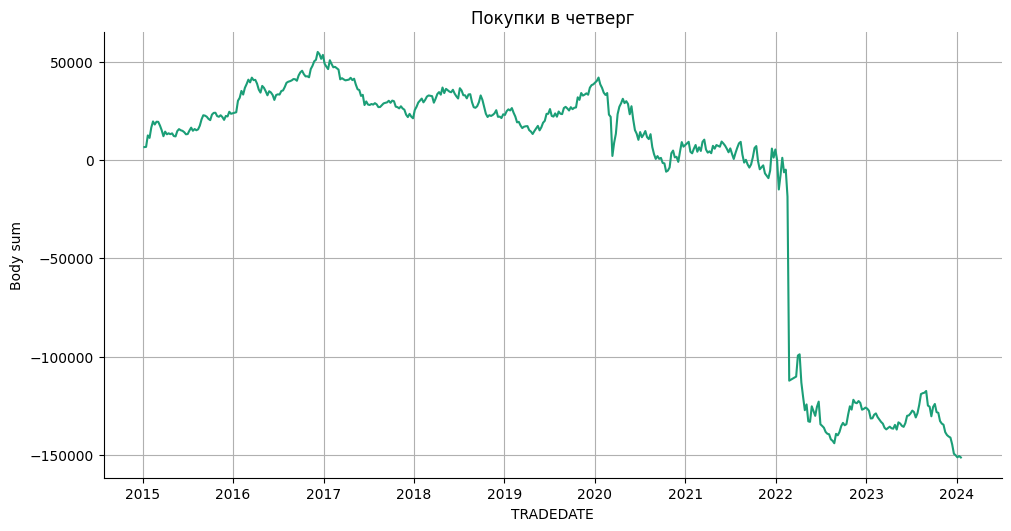

In [114]:
df_thursday = df.copy(deep=True)  # Создание копии
df_thursday = df_thursday.loc[df_thursday['Work_day'] == 3]  # Выборка по четвергам
df_thursday["Body_cum"] = df_thursday["Body"].cumsum()
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['TRADEDATE']
  ys = series['Body_cum']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_thursday.sort_values('TRADEDATE', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('TRADEDATE')
plt.title('Покупки в четверг')
plt.grid()
_ = plt.ylabel('Body sum')

---

Построение графика результата при покупке по пятницам.

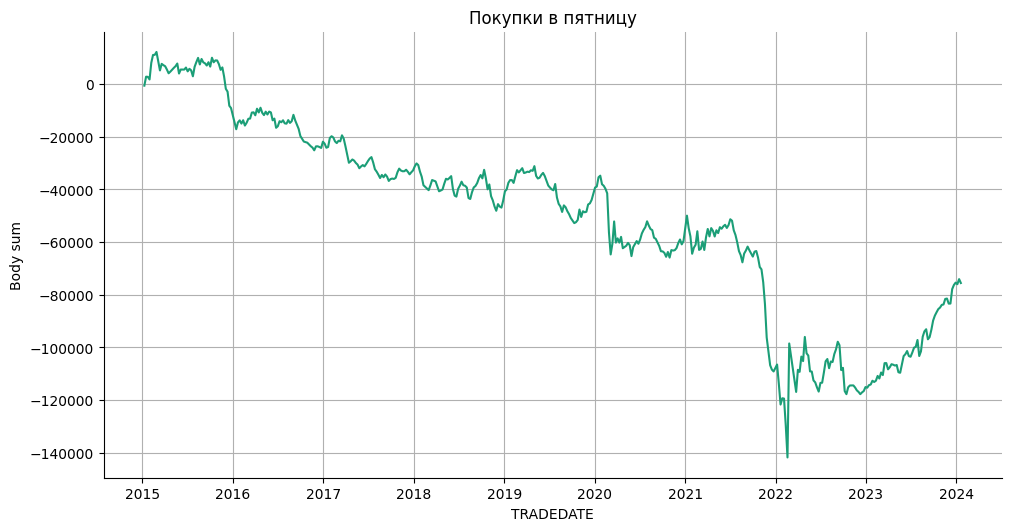

In [115]:
df_friday = df.copy(deep=True)  # Создание копии
df_friday = df_friday.loc[df_friday['Work_day'] == 4]  # Выборка по пятницам
df_friday["Body_cum"] = df_friday["Body"].cumsum()
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['TRADEDATE']
  ys = series['Body_cum']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_friday.sort_values('TRADEDATE', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('TRADEDATE')
plt.title('Покупки в пятницу')
plt.grid()
_ = plt.ylabel('Body sum')

---

Построение графика результата при покупке по понедельникам, вторникам и средам.  


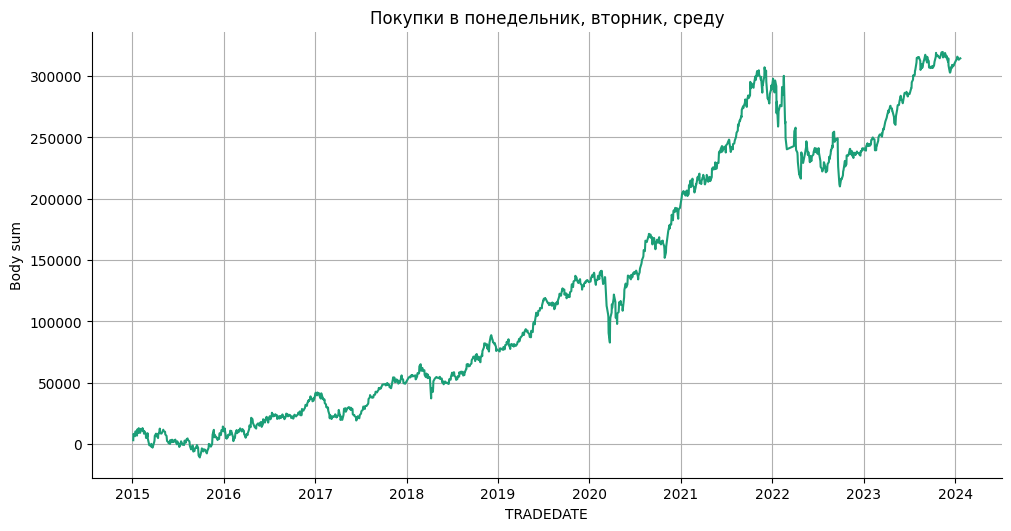

In [116]:
df_3d = df.copy(deep=True)  # Создание копии
df_3d = df_3d.loc[df_3d['Work_day'] < 3]  # Выборка по понедельникам, вторникам и средам
df_3d["Body_cum"] = df_3d["Body"].cumsum()
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['TRADEDATE']
  ys = series['Body_cum']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_3d.sort_values('TRADEDATE', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('TRADEDATE')
plt.title('Покупки в понедельник, вторник, среду')
plt.grid()
_ = plt.ylabel('Body sum')

По графику заметны просадки на СВО и КОВИД.

---

Построение графика результата при продажах по четвергам.

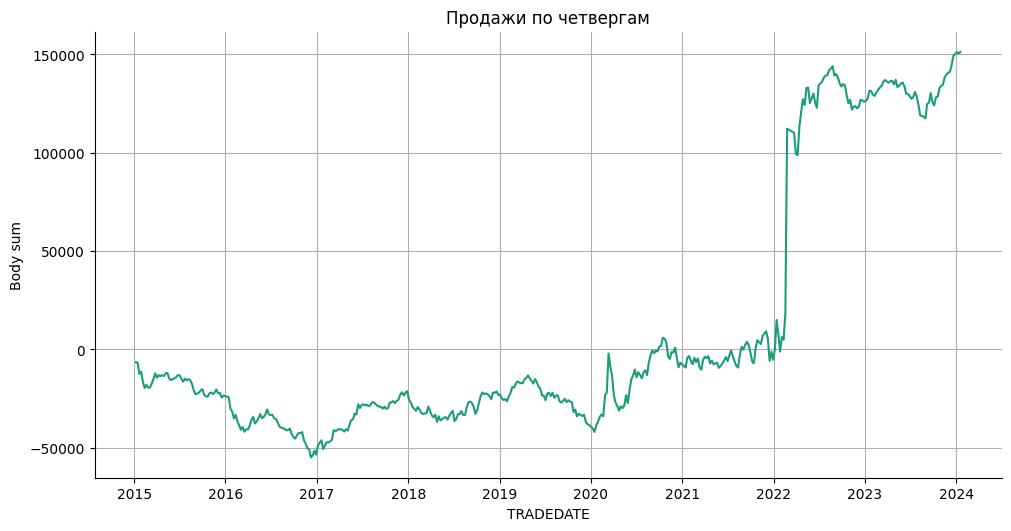

In [117]:
df_thursday = df.copy(deep=True)  # Создание копии
df_thursday = df_thursday.loc[df_thursday['Work_day'] == 3]  # Выборка по четвергам
df_thursday['Body'] = df_thursday['Body'] * (-1)
df_thursday["Body_cum"] = df_thursday["Body"].cumsum()
# print(df_thursday.to_string(max_rows=6, max_cols=25))  # Проверка
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['TRADEDATE']
  ys = series['Body_cum']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_thursday.sort_values('TRADEDATE', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('TRADEDATE')
plt.title('Продажи по четвергам')
plt.grid()
_ = plt.ylabel('Body sum')

Продажи по четвергам дают хорошую прибыль во время массовых паник СВО и КОВИД

---

Построение графика результата при продажах по пятницам.

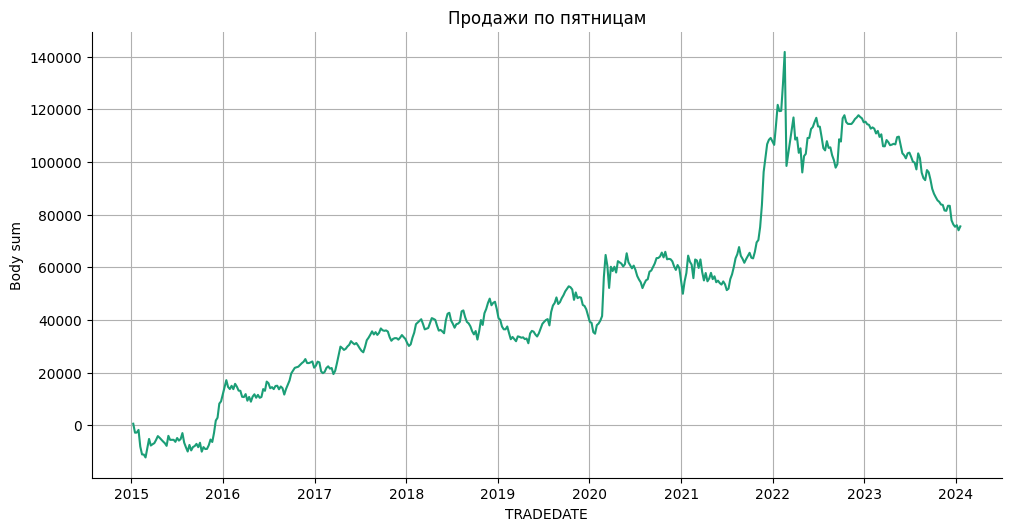

In [118]:
df_friday = df.copy(deep=True)  # Создание копии
df_friday = df_friday.loc[df_friday['Work_day'] == 4]  # Выборка по четвергам
df_friday['Body'] = df_friday['Body'] * (-1)
df_friday["Body_cum"] = df_friday["Body"].cumsum()
# print(df_thursday.to_string(max_rows=6, max_cols=25))  # Проверка
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['TRADEDATE']
  ys = series['Body_cum']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_friday.sort_values('TRADEDATE', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('TRADEDATE')
plt.title('Продажи по пятницам')
plt.grid()
_ = plt.ylabel('Body sum')

Продажи по пятницам до 2022 дают прибыль, а с началом СВО дают убытки. Вероятно это связано с уходом из России иностранных инвесторов.